In [1]:
%matplotlib inline
import sys 
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.stats as st
import pandas as pd
import random
import string
import time
import seaborn as sns
from collections import defaultdict

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/Users/arda/miniconda3/envs/python2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
work_path = '/Users/arda/Research/Channing/misc_projects/'
data_path = '/Users/arda/Research/Channing/Datasets/'

In [4]:
symbol2entrez = np.genfromtxt(data_path + 'gene-info-stripped_human', dtype=str)

In [5]:
ppi2015_edges = np.genfromtxt(work_path + 'newHnet-2015.txt', dtype=str)
G_ppi2015 = nx.Graph()
G_ppi2015.add_edges_from(ppi2015_edges[:, 0:2])
G_ppi2015_LCC = max(list(nx.connected_component_subgraphs(G_ppi2015)), key=len)
len(G_ppi2015), len(G_ppi2015_LCC)

(16461, 16418)

In [6]:
PPI2015_nodes_symb = [symbol2entrez[np.where(symbol2entrez[:, 1]==gene)[0][0], 0] for gene in G_ppi2015_LCC.nodes() \
                    if gene in symbol2entrez[:, 1]]

### COPD and IPF modules

In [7]:
copd_seeds = np.genfromtxt(work_path + 'copd_seeds.txt', dtype=str)
ipf_seeds = np.genfromtxt(work_path + 'ipf_seeds.txt', dtype=str)

copd_seeds_entrez = np.array([symbol2entrez[np.where(symbol2entrez[:, 0]==gene)[0][0], 1] for gene in copd_seeds \
                              if gene in symbol2entrez[:, 0]])
ipf_seeds_entrez = np.array([symbol2entrez[np.where(symbol2entrez[:, 0]==gene)[0][0], 1] for gene in ipf_seeds \
                              if gene in symbol2entrez[:, 0]])

len(copd_seeds), len(copd_seeds_entrez), len(ipf_seeds), len(ipf_seeds_entrez)

(30, 30, 17, 16)

In [8]:
copd_module = np.genfromtxt(work_path + 'copd_module.txt', dtype=str)
ipf_module = np.genfromtxt(work_path + 'ipf_module.txt', dtype=str)

len(copd_module), len(ipf_module)

(425, 109)

In [9]:
copd_module_symb = [symbol2entrez[np.where(symbol2entrez[:, 1]==gene)[0][0], 0] for gene in copd_module \
                    if gene in symbol2entrez[:, 1]]
ipf_module_symb = [symbol2entrez[np.where(symbol2entrez[:, 1]==gene)[0][0], 0] for gene in ipf_module \
                    if gene in symbol2entrez[:, 1]]

len(copd_module_symb), len(ipf_module_symb)

(424, 109)

In [10]:
disgenet = pd.read_csv(data_path + 'curated_gene_disease_associations.tsv', sep='\t')
disease_connect = pd.read_csv(data_path + 'Disease-Gene_v1.csv')

In [11]:
disgenet_copd = set(disgenet[disgenet['diseaseName']=='Chronic Obstructive Airway Disease']['geneSymbol'])
disgenet_ipf = set(disgenet[disgenet['diseaseName']=='Idiopathic Pulmonary Fibrosis']['geneSymbol'])
disease_connect_copd = set(disease_connect[disease_connect['Diseas Name']=='Chronic Obstructive Airway Disease']['Gene'])
disease_connect_ipf = set(disease_connect[disease_connect['Diseas Name']=='Idiopathic Pulmonary Fibrosis']['Gene'])

In [12]:
len(disgenet_copd), len(disgenet_ipf)

(38, 15)

In [13]:
disgenet_copd_entrez = []
for gene in disgenet_copd:
    if gene in symbol2entrez[:, 0]:
        disgenet_copd_entrez.append(symbol2entrez[np.where(symbol2entrez[:, 0]==gene)[0][0], 1])
    else:
        print gene
        
disgenet_ipf_entrez = []
for gene in disgenet_ipf:
    if gene in symbol2entrez[:, 0]:
        disgenet_ipf_entrez.append(symbol2entrez[np.where(symbol2entrez[:, 0]==gene)[0][0], 1])
    else:
        print gene
        
disgenet_copd_entrez_PPI = set(disgenet_copd_entrez) & set(G_ppi2015_LCC.nodes())
disgenet_ipf_entrez_PPI = set(disgenet_ipf_entrez) & set(G_ppi2015_LCC.nodes())

len(disgenet_copd_entrez_PPI), len(disgenet_ipf_entrez_PPI)

(37, 14)

In [14]:
A = len(set(copd_module) & set(disgenet_copd_entrez_PPI))
B = len(set(copd_module) - set(disgenet_copd_entrez_PPI))
C = len(set(disgenet_copd_entrez_PPI) - set(copd_module))
D = len(set(G_ppi2015_LCC.nodes()) - (set(copd_module) | set(disgenet_copd_entrez_PPI)))
print(st.fisher_exact([[A, B], [C, D]]))

A = len(set(ipf_module) & set(disgenet_ipf_entrez_PPI))
B = len(set(ipf_module) - set(disgenet_ipf_entrez_PPI))
C = len(set(disgenet_ipf_entrez_PPI) - set(ipf_module))
D = len(set(G_ppi2015_LCC.nodes()) - (set(ipf_module) | set(disgenet_ipf_entrez_PPI)))
print(st.fisher_exact([[A, B], [C, D]]))

(12.335594093406593, 3.1363117061086755e-07)
(1008.680412371134, 3.5365003501450965e-25)


In [15]:
# overlap still significant once the seeds are removed from the comparison (DisGeNet score > 0.3 still works)
A = len((set(copd_module) - set(copd_seeds_entrez)) & (set(disgenet_copd_entrez_PPI) - set(copd_seeds_entrez)))
B = len((set(copd_module) - set(copd_seeds_entrez)) - (set(disgenet_copd_entrez_PPI) - set(copd_seeds_entrez)))
C = len((set(disgenet_copd_entrez_PPI) - set(copd_seeds_entrez)) - (set(copd_module) - set(copd_seeds_entrez)))
D = len(set(G_ppi2015_LCC.nodes()) - ((set(copd_module) - set(copd_seeds_entrez)) | \
        (set(disgenet_copd_entrez_PPI) - set(copd_seeds_entrez))))
print(st.fisher_exact([[A, B], [C, D]]))

A = len((set(ipf_module) - set(ipf_seeds_entrez)) & (set(disgenet_ipf_entrez_PPI) - set(ipf_seeds_entrez)))
B = len((set(ipf_module) - set(ipf_seeds_entrez)) - (set(disgenet_ipf_entrez_PPI) - set(ipf_seeds_entrez)))
C = len((set(disgenet_ipf_entrez_PPI) - set(ipf_seeds_entrez)) - (set(ipf_module) - set(ipf_seeds_entrez)))
D = len(set(G_ppi2015_LCC.nodes()) - ((set(ipf_module) - set(ipf_seeds_entrez)) | \
        (set(disgenet_ipf_entrez_PPI) - set(ipf_seeds_entrez))))
print(st.fisher_exact([[A, B], [C, D]]))

(8.787912087912089, 0.00014385329637895772)
(177.41304347826087, 0.0001931511949483174)


### Overlap and network closeness of COPD and IPF modules

In [16]:
# Given a graph G and (optionally) bins, outputs the degree and binned degree dictionary.
def degree_log_bin(G, nodes=None, log_bins=None):
    
    if nodes is None:
        deg_dict = dict(G.degree())
    else:
        deg_dict = dict(nx.degree(G, nodes))
    #print deg_dict
    
    if log_bins is None:
        log_bins = np.unique(np.logspace(0, np.ceil(np.log10(max(deg_dict.values()))), num=40).astype(int))
    #print log_bins
    
    deg_arr = np.zeros((len(deg_dict), 2))
    for n, entrez in enumerate(sorted([int(x) for x in deg_dict.keys()])):
        deg_arr[n, 0] = entrez
        deg_arr[n, 1] = deg_dict[str(entrez)]

    bin_idx = np.digitize(deg_arr[:, 1], log_bins, right=True)

    # empty bins
    # print set(np.arange(len(log_bins))) - set(bin_idx)

    deg_bin_dict = {}
    for i in set(bin_idx):
        deg_bin_dict[i] = deg_arr[np.where(bin_idx==i)[0], 0].astype(int).astype(str)   
    
    return deg_dict, deg_bin_dict

In [17]:
def select_deg_log_bin(deg_bin_dict, target_deg):
    
    if target_deg <= log_bins[np.abs(log_bins - target_deg).argmin()]:
        target_bin_idx = np.abs(log_bins - target_deg).argmin()
    else:
        target_bin_idx = np.abs(log_bins - target_deg).argmin() + 1
    #target_bin = log_bins[target_bin_idx]
    
    return deg_bin_dict[target_bin_idx]

In [18]:
PPI_log_bins = np.unique(np.logspace(0, np.ceil(np.log10(max(dict(G_ppi2015_LCC.degree()).values()))), num=40)\
                         .astype(int))
deg_dict, deg_bin_dict = degree_log_bin(G_ppi2015_LCC, log_bins=PPI_log_bins)

#### Overlap

In [19]:
copd_ipf_jaccard = 1.0 * len(set(copd_module) & set(ipf_module)) / len(set(copd_module) | set(ipf_module))
print copd_ipf_jaccard

0.0368932038835


In [20]:
PPI_log_bins = np.unique(np.logspace(0, np.ceil(np.log10(max(dict(G_ppi2015_LCC.degree()).values()))), num=40)\
                         .astype(int))
deg_dict, deg_bin_dict = degree_log_bin(G_ppi2015_LCC, log_bins=PPI_log_bins)

In [21]:
#both modules randomized (degree-preserving)
start = time.time()

Nrep = 10000
rand_jaccard = []
copd_module_deg_dict, copd_module_deg_bin_dict = degree_log_bin(G_ppi2015_LCC, nodes=copd_module, \
                                                                log_bins=PPI_log_bins)
ipf_module_deg_dict, ipf_module_deg_bin_dict = degree_log_bin(G_ppi2015_LCC, nodes=ipf_module, \
                                                                log_bins=PPI_log_bins)

for n in range(Nrep):

    ### degree preserving node randomization
    rand_module_copd = []
    for key in copd_module_deg_bin_dict.keys():
        rand_module_copd.extend(random.sample(set(deg_bin_dict[key]), len(copd_module_deg_bin_dict[key])))
        
    rand_module_ipf = []
    for key in ipf_module_deg_bin_dict.keys():
        rand_module_ipf.extend(random.sample(set(deg_bin_dict[key]), len(ipf_module_deg_bin_dict[key])))  
    ### degree preserving node randomization
    
    rand_jaccard.append(1.0 * len(set(rand_module_copd) & set(rand_module_ipf)) / \
                        len(set(rand_module_copd) | set(rand_module_ipf)))

print time.time() - start

68.4036200047


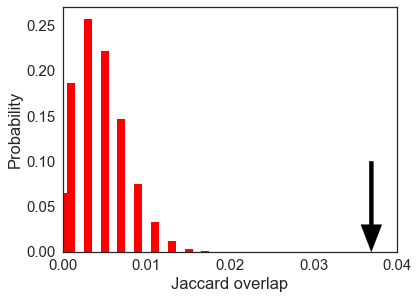

0.00497255373662089 0.002993103982543513


In [22]:
#both modules randomized (degree-preserving)
sns.set(font_scale=1.5)
with sns.axes_style("white"):
    plt.figure(figsize=(6, 4.5))
    nbins = 20
    hist, bin_edges = np.histogram(rand_jaccard, bins=np.linspace(min(rand_jaccard), max(rand_jaccard), nbins))
    plt.bar(bin_edges[:-1], 1.0*hist/Nrep, width=1.0*(max(rand_jaccard)-min(rand_jaccard))/nbins, color='r')
    plt.arrow(copd_ipf_jaccard, 0.10, 0, -0.07, fc='k', ec='k', width=0.0005, head_width=0.0025, head_length=0.03)
    #plt.hist(rand_jaccard, bins=50)
    plt.xlim(0, 0.040)
    plt.xlabel('Jaccard overlap')
    plt.ylabel('Probability')
    plt.savefig('/Users/arda/Desktop/COPD_IPF_jaccard_dist_NEW.pdf', format='pdf', bbox_inches='tight')
    plt.show()
print np.average(rand_jaccard), np.std(rand_jaccard)

In [23]:
#both modules randomized (non degree-preserving)
Nrep = 10000
rand_jaccard = []

for n in range(Nrep):

    rand_module_copd = random.sample(G_ppi2015_LCC, len(copd_module))
    rand_module_ipf = random.sample(G_ppi2015_LCC, len(ipf_module))    
    rand_jaccard.append(1.0 * len(set(rand_module_copd) & set(rand_module_ipf)) / \
                        len(set(rand_module_copd) | set(rand_module_ipf)))

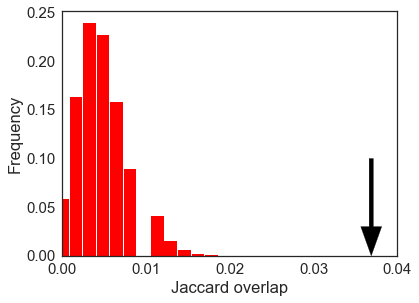

0.005329966427964164 0.003152163978361235


In [24]:
#both modules randomized (non degree-preserving)
sns.set(font_scale=1.5)
with sns.axes_style("white"):
    plt.figure(figsize=(6, 4.5))
    nbins = 14
    hist, bin_edges = np.histogram(rand_jaccard, bins=np.linspace(min(rand_jaccard), max(rand_jaccard), nbins))
    plt.bar(bin_edges[:-1], 1.0*hist/Nrep, width=1.0*(max(rand_jaccard)-min(rand_jaccard))/nbins, color='r')
    plt.arrow(copd_ipf_jaccard, 0.10, 0, -0.07, fc='k', ec='k', width=0.0005, head_width=0.0025, head_length=0.03)
    plt.xlim(0, 0.040)
    plt.xlabel('Jaccard overlap')
    plt.ylabel('Frequency')
    plt.savefig('/Users/arda/Desktop/COPD_IPF_jaccard_dist_NEW_nondegpres.pdf', format='pdf', bbox_inches='tight')
    plt.show()
print np.average(rand_jaccard), np.std(rand_jaccard)

In [25]:
print (copd_ipf_jaccard - np.mean(rand_jaccard)) / np.std(rand_jaccard)

10.013196544407014


#### Closeness

In [26]:
copd_ipf_dists = []
for g1 in copd_module:
    for g2 in ipf_module:
        copd_ipf_dists.append(nx.shortest_path_length(G_ppi2015_LCC, source=g1, target=g2))
print np.mean(copd_ipf_dists)

3.04574203993524


In [27]:
#both modules randomized (non degree-preserving)
start = time.time()
rand_av_dists = []
for n in range(100):
    rand_module1 = random.sample(G_ppi2015_LCC, len(copd_module))
    rand_module2 = random.sample(G_ppi2015_LCC, len(ipf_module))
    dists = []
    for g1 in rand_module1:
        for g2 in rand_module2:
            dists.append(nx.shortest_path_length(G_ppi2015_LCC, source=g1, target=g2))
    rand_av_dists.append(np.average(dists))
end = time.time()
print end - start

988.080840826


/Users/arda/miniconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  """


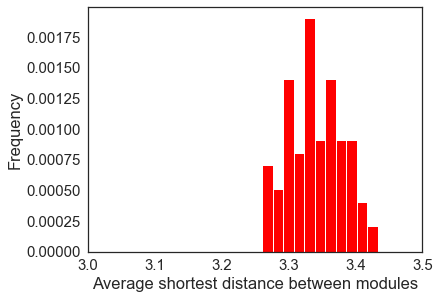

3.3481616837560724 0.04057043627817145


In [28]:
#both modules randomized (non degree-preserving)
with sns.axes_style("white"):
    nbins = 12.0
    plt.figure(figsize=(6, 4.5))
    hist, bin_edges = np.histogram(rand_av_dists, bins=np.linspace(min(rand_av_dists), max(rand_av_dists), nbins))
    plt.bar(bin_edges[:-1], 1.0*hist/Nrep, width=(max(rand_av_dists)-min(rand_av_dists))/nbins, color='r')
    plt.xlim(3.0, 3.5)
    plt.xlabel('Average shortest distance between modules')
    plt.ylabel('Frequency')
    plt.savefig('/Users/arda/Desktop/COPD_IPF_closeness_dist_NEW_nondegpres.pdf', format='pdf', bbox_inches='tight')
    plt.show()
print np.average(rand_av_dists), np.std(rand_av_dists)

In [29]:
print (np.average(copd_ipf_dists) - np.average(rand_av_dists)) / np.std(rand_av_dists)

-7.454187619459894


### Validation using the LTRC gene expression data

#### "Dataset 1": GPL14550

In [30]:
platform_14450 = pd.read_csv(work_path + 'GPL14550-9757.txt', sep='\t')

In [31]:
GSE47460_copd = pd.read_csv(work_path + 'GSE47460_copd_vs_ctrl.txt', sep='\t')
GSE47460_ipf = pd.read_csv(work_path + 'GSE47460_ipf_vs_ctrl.txt', sep='\t')

In [32]:
start = time.time()
GSE47460_copd_symb = []
for n, gene in enumerate(GSE47460_copd['ID']):
    GSE47460_copd_symb.append(platform_14450[platform_14450['ID']==gene]['GENE_SYMBOL'].values[0])
end = time.time()
print end - start

start = time.time()
GSE47460_ipf_symb = []
for n, gene in enumerate(GSE47460_ipf['ID']):
    GSE47460_ipf_symb.append(platform_14450[platform_14450['ID']==gene]['GENE_SYMBOL'].values[0])
end = time.time()
print end - start

61.180366993
61.2943439484


In [33]:
GSE47460_copd.insert(0, 'Gene.symbol', GSE47460_copd_symb)
GSE47460_ipf.insert(0, 'Gene.symbol', GSE47460_ipf_symb)

In [34]:
# discard entries with no gene symbol or FC
GSE47460_copd = GSE47460_copd[~pd.isnull(GSE47460_copd['Gene.symbol'])]
GSE47460_copd = GSE47460_copd[~pd.isnull(GSE47460_copd['logFC'])]

GSE47460_ipf = GSE47460_ipf[~pd.isnull(GSE47460_ipf['Gene.symbol'])]
GSE47460_ipf = GSE47460_ipf[~pd.isnull(GSE47460_ipf['logFC'])]

In [35]:
# 1) "other_FCs" mean only the genes in the interactome
# 2) seed genes are excluded

GSE47460_ipf_rawp = GSE47460_ipf[GSE47460_ipf['P.Value']<0.05]
module_FCs = GSE47460_ipf_rawp[GSE47460_ipf_rawp['Gene.symbol'].isin((set(ipf_module_symb) - set(ipf_seeds)))]['logFC'].values
other_FCs = GSE47460_ipf[GSE47460_ipf['Gene.symbol'].isin(set(PPI2015_nodes_symb) - (set(ipf_module_symb)))]['logFC'].values

print np.mean(np.abs(module_FCs)), np.mean(np.abs(other_FCs))
print st.mannwhitneyu(np.abs(module_FCs), np.abs(other_FCs))


GSE47460_ipf_adjp = GSE47460_ipf[GSE47460_ipf['adj.P.Val']<0.05]
module_FCs = GSE47460_ipf_adjp[GSE47460_ipf_adjp['Gene.symbol'].isin((set(ipf_module_symb) - set(ipf_seeds)))]['logFC'].values
other_FCs = GSE47460_ipf[GSE47460_ipf['Gene.symbol'].isin(set(PPI2015_nodes_symb) - (set(ipf_module_symb)))]['logFC'].values

print np.mean(np.abs(module_FCs)), np.mean(np.abs(other_FCs))
print st.mannwhitneyu(np.abs(module_FCs), np.abs(other_FCs))

0.28589216037735854 0.28952383456310676
MannwhitneyuResult(statistic=281490.0, pvalue=0.01384487206477454)
0.2993267959183674 0.28952383456310676
MannwhitneyuResult(statistic=248098.0, pvalue=0.00489338844949263)


In [36]:
# 1) "other_FCs" mean only the genes in the interactome
# 2) seed genes are excluded

GSE47460_copd_rawp = GSE47460_copd[GSE47460_copd['P.Value']<0.05]
module_FCs = GSE47460_copd_rawp[GSE47460_copd_rawp['Gene.symbol'].isin((set(copd_module_symb) - set(copd_seeds)))]['logFC'].values
other_FCs = GSE47460_copd[GSE47460_copd['Gene.symbol'].isin(set(PPI2015_nodes_symb) - (set(copd_module_symb)))]['logFC'].values

print np.mean(np.abs(module_FCs)), np.mean(np.abs(other_FCs))
print st.mannwhitneyu(np.abs(module_FCs), np.abs(other_FCs))

GSE47460_copd_adjp = GSE47460_copd[GSE47460_copd['adj.P.Val']<0.05]
module_FCs = GSE47460_copd_adjp[GSE47460_copd_adjp['Gene.symbol'].isin((set(copd_module_symb) - set(copd_seeds)))]['logFC'].values
other_FCs = GSE47460_copd[GSE47460_copd['Gene.symbol'].isin(set(PPI2015_nodes_symb) - (set(copd_module_symb)))]['logFC'].values

print np.mean(np.abs(module_FCs)), np.mean(np.abs(other_FCs))
print st.mannwhitneyu(np.abs(module_FCs), np.abs(other_FCs))

0.2651899802702703 0.10785604631150135
MannwhitneyuResult(statistic=249103.0, pvalue=5.171071030526201e-32)
0.3122996412162162 0.10785604631150135
MannwhitneyuResult(statistic=127426.0, pvalue=1.5661766400306684e-27)


#### "Dataset 2": GPL6480

In [37]:
GSE47460_copd_2 = pd.read_csv(work_path + 'GSE47460_copd_vs_ctrl_2.txt', sep='\t')
GSE47460_ipf_2 = pd.read_csv(work_path + 'GSE47460_ipf_vs_ctrl_2.txt', sep='\t')

In [38]:
GSE47460_copd_2 = GSE47460_copd_2[~pd.isnull(GSE47460_copd_2['Gene.symbol'])]
GSE47460_copd_2 = GSE47460_copd_2[~pd.isnull(GSE47460_copd_2['logFC'])]

GSE47460_ipf_2 = GSE47460_ipf_2[~pd.isnull(GSE47460_ipf_2['Gene.symbol'])]
GSE47460_ipf_2 = GSE47460_ipf_2[~pd.isnull(GSE47460_ipf_2['logFC'])]

In [39]:
# 1) "other_FCs" mean only the genes in the interactome
# 2) seed genes are excluded

GSE47460_ipf_rawp_2 = GSE47460_ipf_2[GSE47460_ipf_2['P.Value']<0.05]
module_FCs = GSE47460_ipf_rawp_2[GSE47460_ipf_rawp_2['Gene.symbol'].isin((set(ipf_module_symb) - set(ipf_seeds)))]['logFC'].values
other_FCs = GSE47460_ipf_2[GSE47460_ipf_2['Gene.symbol'].isin(set(PPI2015_nodes_symb) - (set(ipf_module_symb)))]['logFC'].values
#other_FCs = GSE47460_ipf_2[~GSE47460_ipf_2['Gene.symbol'].isin(ipf_module_symb)]['logFC'].values

# print max(np.abs(module_FCs)), max(np.abs(other_FCs))
print np.mean(np.abs(module_FCs)), np.mean(np.abs(other_FCs))
print st.mannwhitneyu(np.abs(module_FCs), np.abs(other_FCs))


GSE47460_ipf_adjp_2 = GSE47460_ipf_2[GSE47460_ipf_2['adj.P.Val']<0.05]
module_FCs = GSE47460_ipf_adjp_2[GSE47460_ipf_adjp_2['Gene.symbol'].isin((set(ipf_module_symb) - set(ipf_seeds)))]['logFC'].values
other_FCs = GSE47460_ipf_2[GSE47460_ipf_2['Gene.symbol'].isin(set(PPI2015_nodes_symb) - (set(ipf_module_symb)))]['logFC'].values
#other_FCs = GSE47460_ipf_2[~GSE47460_ipf_2['Gene.symbol'].isin(ipf_module_symb)]['logFC'].values

# print max(np.abs(module_FCs)), max(np.abs(other_FCs))
print np.mean(np.abs(module_FCs)), np.mean(np.abs(other_FCs))
print st.mannwhitneyu(np.abs(module_FCs), np.abs(other_FCs))

0.48894325000000016 0.3821189248834737
MannwhitneyuResult(statistic=132648.0, pvalue=0.00013102786977606641)
0.5514573214285714 0.3821189248834737
MannwhitneyuResult(statistic=91490.0, pvalue=1.0114417512774655e-05)


In [40]:
# 1) "other_FCs" mean only the genes in the interactome
# 2) seed genes are excluded

GSE47460_copd_rawp_2 = GSE47460_copd_2[GSE47460_copd_2['P.Value']<0.05]
module_FCs = GSE47460_copd_rawp_2[GSE47460_copd_rawp_2['Gene.symbol'].isin((set(copd_module_symb) - set(copd_seeds)))]['logFC'].values
other_FCs = GSE47460_copd_2[GSE47460_copd_2['Gene.symbol'].isin(set(PPI2015_nodes_symb) - (set(copd_module_symb)))]['logFC'].values

print np.mean(np.abs(module_FCs)), np.mean(np.abs(other_FCs))
print st.mannwhitneyu(np.abs(module_FCs), np.abs(other_FCs))


GSE47460_copd_adjp_2 = GSE47460_copd_2[GSE47460_copd_2['adj.P.Val']<0.05]
module_FCs = GSE47460_copd_adjp_2[GSE47460_copd_adjp_2['Gene.symbol'].isin((set(copd_module_symb) - set(copd_seeds)))]['logFC'].values
other_FCs = GSE47460_copd_2[GSE47460_copd_2['Gene.symbol'].isin(set(PPI2015_nodes_symb) - (set(copd_module_symb)))]['logFC'].values

print np.mean(np.abs(module_FCs)), np.mean(np.abs(other_FCs))
print st.mannwhitneyu(np.abs(module_FCs), np.abs(other_FCs))

0.6023580348648648 0.16036717310709528
MannwhitneyuResult(statistic=40676.0, pvalue=4.238852145505262e-18)
1.10944506 0.16036717310709528
MannwhitneyuResult(statistic=437.0, pvalue=0.009138695544194506)


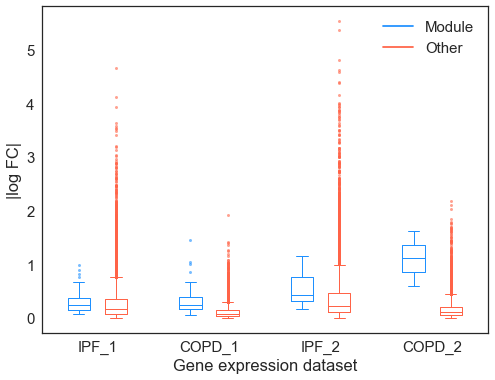

In [41]:
#"other genes" defined as all other in the microarray

def setBoxColors(bp):
    plt.setp(bp['boxes'][0], color='dodgerblue')
    plt.setp(bp['caps'][0], color='dodgerblue')
    plt.setp(bp['caps'][1], color='dodgerblue')
    plt.setp(bp['whiskers'][0], color='dodgerblue')
    plt.setp(bp['whiskers'][1], color='dodgerblue')
    plt.setp(bp['fliers'][0], color='dodgerblue')
    plt.setp(bp['fliers'][1], color='dodgerblue')
    plt.setp(bp['medians'][0], color='dodgerblue')

    plt.setp(bp['boxes'][1], color='tomato')
    plt.setp(bp['caps'][2], color='tomato')
    plt.setp(bp['caps'][3], color='tomato')
    plt.setp(bp['whiskers'][2], color='tomato')
    plt.setp(bp['whiskers'][3], color='tomato')
    #plt.setp(bp['fliers'][2], color='tomato')
    #plt.setp(bp['fliers'][3], color='tomato')
    plt.setp(bp['medians'][1], color='tomato')

sns.set(font_scale=1.5)
with sns.axes_style("white"):
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes()
    cols = ['dodgerblue', 'tomato']

    bp = plt.boxplot([np.abs(GSE47460_ipf_adjp[GSE47460_ipf_adjp['Gene.symbol'].isin((set(ipf_module_symb) - set(ipf_seeds)))]['logFC'].values), \
                np.abs(GSE47460_ipf[GSE47460_ipf['Gene.symbol'].isin(set(PPI2015_nodes_symb) - (set(ipf_module_symb)))]['logFC'].values)], positions = [1, 2], \
                widths = 0.6, flierprops={'alpha':0.6, 'markeredgecolor': 'None', 'marker': '.'})
    for f, fc in zip(bp['fliers'], cols):
        f.set_markerfacecolor(fc)
    setBoxColors(bp)

    bp = plt.boxplot([np.abs(GSE47460_copd_adjp[GSE47460_copd_adjp['Gene.symbol'].isin((set(copd_module_symb) - set(copd_seeds)))]['logFC'].values), \
                np.abs(GSE47460_copd[GSE47460_copd['Gene.symbol'].isin(set(PPI2015_nodes_symb) - (set(copd_module_symb)))]['logFC'].values)], positions = [4, 5], \
                widths = 0.6, flierprops={'alpha':0.6, 'markeredgecolor': 'None', 'marker': '.'})
    for f, fc in zip(bp['fliers'], cols):
        f.set_markerfacecolor(fc)
    setBoxColors(bp)

    bp = plt.boxplot([np.abs(GSE47460_ipf_adjp_2[GSE47460_ipf_adjp_2['Gene.symbol'].isin((set(ipf_module_symb) - set(ipf_seeds)))]['logFC'].values), \
                np.abs(GSE47460_ipf_2[GSE47460_ipf_2['Gene.symbol'].isin(set(PPI2015_nodes_symb) - (set(ipf_module_symb)))]['logFC'].values)], positions = [7, 8], \
                widths = 0.6, flierprops={'alpha':0.6, 'markeredgecolor': 'None', 'marker': '.'})
    for f, fc in zip(bp['fliers'], cols):
        f.set_markerfacecolor(fc)
    setBoxColors(bp)

    bp = plt.boxplot([np.abs(GSE47460_copd_adjp_2[GSE47460_copd_adjp_2['Gene.symbol'].isin((set(copd_module_symb) - set(copd_seeds)))]['logFC'].values), \
                np.abs(GSE47460_copd_2[GSE47460_copd_2['Gene.symbol'].isin(set(PPI2015_nodes_symb) - (set(copd_module_symb)))]['logFC'].values)], positions = [10, 11], \
                widths = 0.6, flierprops={'alpha':0.6, 'markeredgecolor': 'None', 'marker': '.'})
    for f, fc in zip(bp['fliers'], cols):
        f.set_markerfacecolor(fc)
    setBoxColors(bp)

    # set axes limits and labels
    hB, = plt.plot([1,1],'dodgerblue')
    hR, = plt.plot([1,1],'tomato')
    plt.legend((hB, hR),('Module', 'Other'))
    plt.xlim(0, 6)
    #plt.ylim(-1, 6)
    ax.set_xticklabels(['IPF_1', 'COPD_1', 'IPF_2', 'COPD_2'])
    ax.set_xticks([1.5, 4.5, 7.5, 10.5, 12])

    # draw temporary red and blue lines and use them to create a legend
    hB.set_visible(False)
    hR.set_visible(False)
    plt.ylabel('|log FC|')
    plt.xlabel('Gene expression dataset')
    plt.savefig('/Users/arda/Desktop/copd_ipf_DE_enrichment_adjp_noseeds.pdf', format='pdf', bbox_inches='tight')
    plt.show()

In [42]:
# For supplementary Table 2: change temp_gene to get the respective FC and p-values
temp_gene = 'BCHE'
print GSE47460_ipf_rawp[GSE47460_ipf_rawp['Gene.symbol']==temp_gene]['logFC']
print GSE47460_ipf_rawp[GSE47460_ipf_rawp['Gene.symbol']==temp_gene]['P.Value']
print GSE47460_ipf_rawp[GSE47460_ipf_rawp['Gene.symbol']==temp_gene]['adj.P.Val']
print
print GSE47460_ipf_rawp_2[GSE47460_ipf_rawp_2['Gene.symbol']==temp_gene]['logFC']
print GSE47460_ipf_rawp_2[GSE47460_ipf_rawp_2['Gene.symbol']==temp_gene]['P.Value']
print GSE47460_ipf_rawp_2[GSE47460_ipf_rawp_2['Gene.symbol']==temp_gene]['adj.P.Val']
print
print GSE47460_copd_rawp[GSE47460_copd_rawp['Gene.symbol']==temp_gene]['logFC']
print GSE47460_copd_rawp[GSE47460_copd_rawp['Gene.symbol']==temp_gene]['P.Value']
print GSE47460_copd_rawp[GSE47460_copd_rawp['Gene.symbol']==temp_gene]['adj.P.Val']
print
print GSE47460_copd_rawp_2[GSE47460_copd_rawp_2['Gene.symbol']==temp_gene]['logFC']
print GSE47460_copd_rawp_2[GSE47460_copd_rawp_2['Gene.symbol']==temp_gene]['P.Value']
print GSE47460_copd_rawp_2[GSE47460_copd_rawp_2['Gene.symbol']==temp_gene]['adj.P.Val']

1989    0.770511
Name: logFC, dtype: float64
1989    3.190000e-13
Name: P.Value, dtype: float64
1989    2.450000e-12
Name: adj.P.Val, dtype: float64

3822    0.746564
Name: logFC, dtype: float64
3822    0.00149
Name: P.Value, dtype: float64
3822    0.00593
Name: adj.P.Val, dtype: float64

2698   -0.306562
Name: logFC, dtype: float64
2698    0.00498
Name: P.Value, dtype: float64
2698    0.0282
Name: adj.P.Val, dtype: float64

433   -0.70332
Name: logFC, dtype: float64
433    0.00305
Name: P.Value, dtype: float64
433    0.10689
Name: adj.P.Val, dtype: float64


### Up- and down-regulated genes of COPD and IPF modules

In [43]:
print len(GSE47460_copd_rawp[GSE47460_copd_rawp['Gene.symbol'].isin(copd_module_symb)])
print len(GSE47460_copd_rawp_2[GSE47460_copd_rawp_2['Gene.symbol'].isin(copd_module_symb)])
print len(GSE47460_ipf_rawp[GSE47460_ipf_rawp['Gene.symbol'].isin(ipf_module_symb)])
print len(GSE47460_ipf_rawp_2[GSE47460_ipf_rawp_2['Gene.symbol'].isin(ipf_module_symb)])

118
42
62
42


In [44]:
print len(GSE47460_copd_adjp[GSE47460_copd_adjp['Gene.symbol'].isin(copd_module_symb)])
print len(GSE47460_copd_adjp_2[GSE47460_copd_adjp_2['Gene.symbol'].isin(copd_module_symb)])
print len(GSE47460_ipf_adjp[GSE47460_ipf_adjp['Gene.symbol'].isin(ipf_module_symb)])
print len(GSE47460_ipf_adjp_2[GSE47460_ipf_adjp_2['Gene.symbol'].isin(ipf_module_symb)])

79
3
57
35


#### COPD

In [45]:
COPD_module_rawp_FC = GSE47460_copd_rawp[GSE47460_copd_rawp['Gene.symbol'].isin(copd_module_symb)][['Gene.symbol', 'logFC']]
COPD_module_rawp_FC_2 = GSE47460_copd_rawp_2[GSE47460_copd_rawp_2['Gene.symbol'].isin(copd_module_symb)][['Gene.symbol', 'logFC']]

COPD_module_rawp_FC_2_arr = np.zeros(len(COPD_module_rawp_FC))
for i, gene in enumerate(COPD_module_rawp_FC['Gene.symbol'].values):
    if gene in COPD_module_rawp_FC_2['Gene.symbol'].values:
        COPD_module_rawp_FC_2_arr[i] = COPD_module_rawp_FC_2[COPD_module_rawp_FC_2['Gene.symbol']==gene]['logFC'].values[0]
    else:
        COPD_module_rawp_FC_2_arr[i] = 0
        
COPD_module_rawp_FC['logFC-2'] = pd.Series(COPD_module_rawp_FC_2_arr, index=COPD_module_rawp_FC.index)

for gene in set(COPD_module_rawp_FC_2['Gene.symbol']) - set(COPD_module_rawp_FC['Gene.symbol']):
    #pd.Series([gene, 0, 1])
    COPD_module_rawp_FC.loc[len(COPD_module_rawp_FC)] = [gene, 0, \
                                            GSE47460_copd_rawp_2[GSE47460_copd_rawp_2['Gene.symbol']==gene]['logFC'].values[0]]

In [46]:
COPD_module_adjp_FC = GSE47460_copd_adjp[GSE47460_copd_adjp['Gene.symbol'].isin(copd_module_symb)][['Gene.symbol', 'logFC']]
COPD_module_adjp_FC_2 = GSE47460_copd_adjp_2[GSE47460_copd_adjp_2['Gene.symbol'].isin(copd_module_symb)][['Gene.symbol', 'logFC']]

COPD_module_adjp_FC_2_arr = np.zeros(len(COPD_module_adjp_FC))
for i, gene in enumerate(COPD_module_adjp_FC['Gene.symbol'].values):
    if gene in COPD_module_adjp_FC_2['Gene.symbol'].values:
        COPD_module_adjp_FC_2_arr[i] = COPD_module_adjp_FC_2[COPD_module_adjp_FC_2['Gene.symbol']==gene]['logFC'].values[0]
    else:
        COPD_module_adjp_FC_2_arr[i] = 0
        
COPD_module_adjp_FC['logFC-2'] = pd.Series(COPD_module_adjp_FC_2_arr, index=COPD_module_adjp_FC.index)

for gene in set(COPD_module_adjp_FC_2['Gene.symbol']) - set(COPD_module_adjp_FC['Gene.symbol']):
    #pd.Series([gene, 0, 1])
    COPD_module_adjp_FC.loc[len(COPD_module_adjp_FC)] = [gene, 0, \
                                            GSE47460_copd_adjp_2[GSE47460_copd_adjp_2['Gene.symbol']==gene]['logFC'].values[0]]

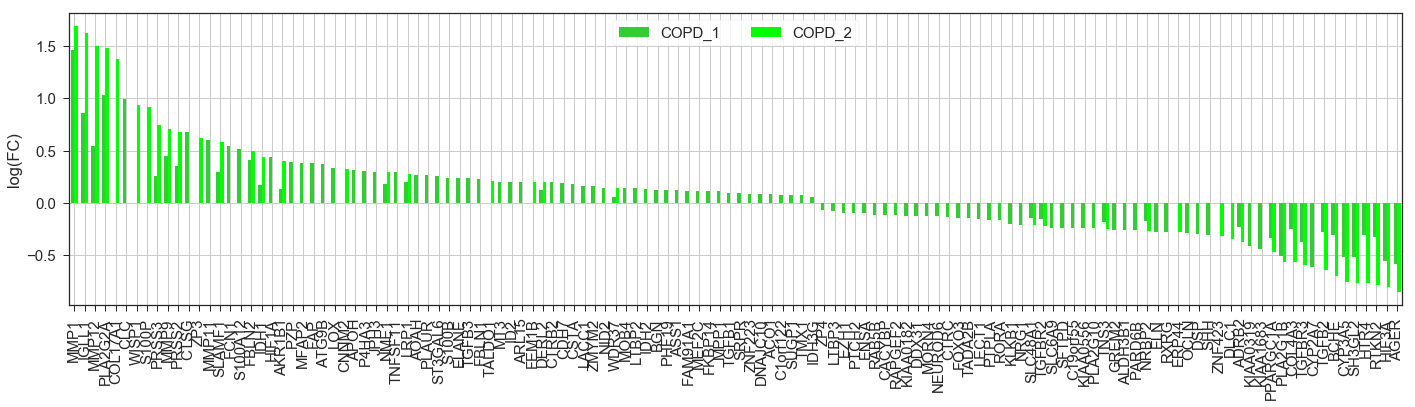

In [47]:
with sns.axes_style("ticks"):
    n_groups = len(COPD_module_rawp_FC)

    f, ax = plt.subplots(figsize=(20, 6))

    index = np.arange(n_groups)
    bar_width = 0.34

    opacity = 1.0
    error_config1 = {'ecolor': 'red', 'lw': 1, 'capthick': 1, 'capsize': 1}
    error_config2 = {'ecolor': 'orange', 'lw': 1, 'capthick': 1, 'capsize': 1}
    error_config3 = {'ecolor': 'dodgerblue', 'lw': 1, 'capthick': 1, 'capsize': 1}
    error_config4 = {'ecolor': 'limegreen', 'lw': 1, 'capthick': 1, 'capsize': 1}

    # treat positive and negative separately for the bar order
    temp_df_pos = COPD_module_rawp_FC[COPD_module_rawp_FC['logFC'] + COPD_module_rawp_FC['logFC-2'] > 0]
    pos_idx = np.argsort(-np.max(temp_df_pos[['logFC', 'logFC-2']].values, axis=1))
    temp_df_neg = COPD_module_rawp_FC[COPD_module_rawp_FC['logFC'] + COPD_module_rawp_FC['logFC-2'] < 0]
    neg_idx = np.argsort(-np.min(temp_df_neg[['logFC', 'logFC-2']].values, axis=1))

    rects1 = plt.bar(index + bar_width, np.concatenate([temp_df_pos['logFC'].values[pos_idx], \
                            temp_df_neg['logFC'].values[neg_idx]]), bar_width, linewidth = 0,
                     alpha=opacity, color='limegreen', label='COPD_1')

    rects2 = plt.bar(index + 2.0*bar_width, np.concatenate([temp_df_pos['logFC-2'].values[pos_idx], \
                            temp_df_neg['logFC-2'].values[neg_idx]]), bar_width, linewidth = 0,
                     alpha=opacity, color='lime', label='COPD_2')

    plt.ylabel('log(FC)')
    #plt.xlabel('Gene')
    #plt.title('COPD_1 and COPD_2 log(FC)')
    plt.xticks(index + bar_width*1.5, np.concatenate([temp_df_pos['Gene.symbol'].values[pos_idx], temp_df_neg['Gene.symbol'].values[neg_idx]]))
    ax.legend(ncol=2, loc=9, frameon=True)
    #sns.despine(offset=5)
    plt.xticks(rotation=90)
    plt.tight_layout()
    ax.yaxis.grid()
    ax.xaxis.grid()
    ax.set_xlim(0, n_groups)
    plt.savefig('/Users/arda/Desktop/COPD_FC_rawp_NEW1.pdf', format='pdf', bbox_extra_artists=(), bbox_inches='tight')
    plt.show()

#### IPF

In [48]:
IPF_module_rawp_FC = GSE47460_ipf_rawp[GSE47460_ipf_rawp['Gene.symbol'].isin(ipf_module_symb)][['Gene.symbol', 'logFC']]
IPF_module_rawp_FC_2 = GSE47460_ipf_rawp_2[GSE47460_ipf_rawp_2['Gene.symbol'].isin(ipf_module_symb)][['Gene.symbol', 'logFC']]

IPF_module_rawp_FC_2_arr = np.zeros(len(IPF_module_rawp_FC))
for i, gene in enumerate(IPF_module_rawp_FC['Gene.symbol'].values):
    if gene in IPF_module_rawp_FC_2['Gene.symbol'].values:
        IPF_module_rawp_FC_2_arr[i] = IPF_module_rawp_FC_2[IPF_module_rawp_FC_2['Gene.symbol']==gene]['logFC'].values[0]
    else:
        IPF_module_rawp_FC_2_arr[i] = 0
        
IPF_module_rawp_FC['logFC-2'] = pd.Series(IPF_module_rawp_FC_2_arr, index=IPF_module_rawp_FC.index)

for gene in set(IPF_module_rawp_FC_2['Gene.symbol']) - set(IPF_module_rawp_FC['Gene.symbol']):
    #pd.Series([gene, 0, 1])
    IPF_module_rawp_FC.loc[len(IPF_module_rawp_FC)] = [gene, 0, \
                                            GSE47460_ipf_rawp_2[GSE47460_ipf_rawp_2['Gene.symbol']==gene]['logFC'].values[0]]

In [49]:
IPF_module_adjp_FC = GSE47460_ipf_adjp[GSE47460_ipf_adjp['Gene.symbol'].isin(ipf_module_symb)][['Gene.symbol', 'logFC']]
IPF_module_adjp_FC_2 = GSE47460_ipf_adjp_2[GSE47460_ipf_adjp_2['Gene.symbol'].isin(ipf_module_symb)][['Gene.symbol', 'logFC']]

IPF_module_adjp_FC_2_arr = np.zeros(len(IPF_module_adjp_FC))
for i, gene in enumerate(IPF_module_adjp_FC['Gene.symbol'].values):
    if gene in IPF_module_adjp_FC_2['Gene.symbol'].values:
        IPF_module_adjp_FC_2_arr[i] = IPF_module_adjp_FC_2[IPF_module_adjp_FC_2['Gene.symbol']==gene]['logFC'].values[0]
    else:
        IPF_module_adjp_FC_2_arr[i] = 0
        
IPF_module_adjp_FC['logFC-2'] = pd.Series(IPF_module_adjp_FC_2_arr, index=IPF_module_adjp_FC.index)

for gene in set(IPF_module_adjp_FC_2['Gene.symbol']) - set(IPF_module_adjp_FC['Gene.symbol']):
    #pd.Series([gene, 0, 1])
    IPF_module_adjp_FC.loc[len(IPF_module_adjp_FC)] = [gene, 0, \
                                            GSE47460_ipf_adjp_2[GSE47460_ipf_adjp_2['Gene.symbol']==gene]['logFC'].values[0]]

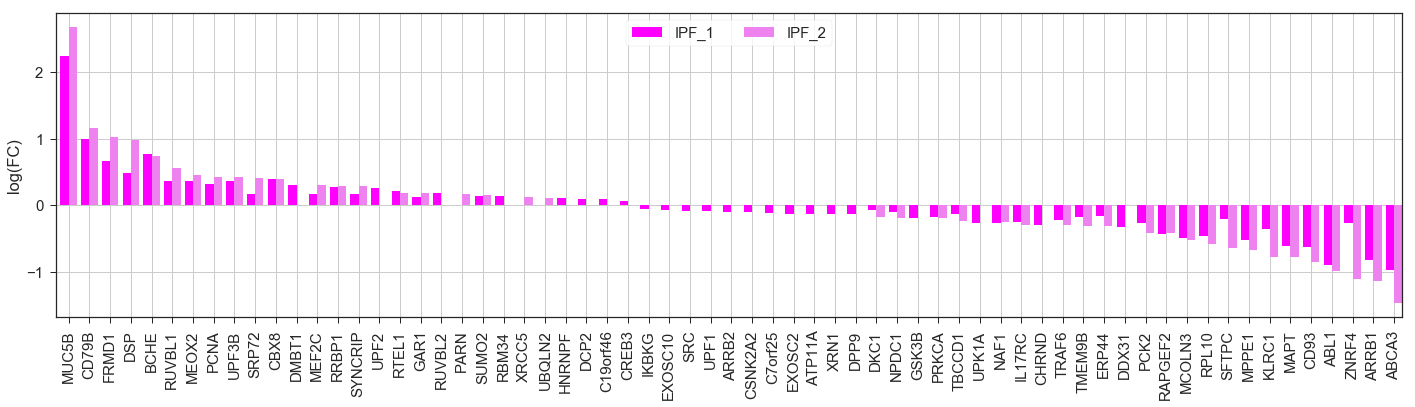

In [50]:
with sns.axes_style("ticks"):
    n_groups = len(IPF_module_rawp_FC)

    f, ax = plt.subplots(figsize=(20, 6))

    index = np.arange(n_groups)
    bar_width = 0.4

    # treat positive and negative separately for the bar order
    temp_df_pos = IPF_module_rawp_FC[IPF_module_rawp_FC['logFC'] + IPF_module_rawp_FC['logFC-2'] > 0]
    pos_idx = np.argsort(-np.max(temp_df_pos[['logFC', 'logFC-2']].values, axis=1))
    temp_df_neg = IPF_module_rawp_FC[IPF_module_rawp_FC['logFC'] + IPF_module_rawp_FC['logFC-2'] < 0]
    neg_idx = np.argsort(-np.min(temp_df_neg[['logFC', 'logFC-2']].values, axis=1))

    rects1 = plt.bar(index + bar_width, np.concatenate([temp_df_pos['logFC'].values[pos_idx], \
                            temp_df_neg['logFC'].values[neg_idx]]), bar_width, linewidth = 0,
                     alpha=opacity, color='magenta', label='IPF_1')

    rects2 = plt.bar(index + 2.0*bar_width, np.concatenate([temp_df_pos['logFC-2'].values[pos_idx], \
                            temp_df_neg['logFC-2'].values[neg_idx]]), bar_width, linewidth = 0,
                     alpha=opacity, color='violet', label='IPF_2')

    plt.ylabel('log(FC)')
    #plt.xlabel('Gene')
    #plt.title('IPF_1 and IPF_2 log(FC)')
    plt.xticks(index + bar_width*1.5, np.concatenate([temp_df_pos['Gene.symbol'].values[pos_idx], temp_df_neg['Gene.symbol'].values[neg_idx]]))
    ax.legend(ncol=2, loc=9, frameon=True)
    #sns.despine(left=True, bottom=True)
    plt.xticks(rotation=90)
    plt.tight_layout()
    ax.yaxis.grid()
    ax.xaxis.grid()
    ax.set_xlim(0, n_groups)
    plt.savefig('/Users/arda/Desktop/IPF_FC_rawp_NEW1.pdf', format='pdf', bbox_extra_artists=(), bbox_inches='tight')
    plt.show()

In [51]:
len(COPD_module_rawp_FC[(COPD_module_rawp_FC['logFC']>0) | (COPD_module_rawp_FC['logFC-2']>0)]),\
len(COPD_module_rawp_FC[(COPD_module_rawp_FC['logFC']<0) | (COPD_module_rawp_FC['logFC-2']<0)]),\
len(IPF_module_rawp_FC[(IPF_module_rawp_FC['logFC']>0) | (IPF_module_rawp_FC['logFC-2']>0)]),\
len(IPF_module_rawp_FC[(IPF_module_rawp_FC['logFC']<0) | (IPF_module_rawp_FC['logFC-2']<0)])

(72, 56, 28, 37)

In [52]:
# up in both
print set(COPD_module_rawp_FC[(COPD_module_rawp_FC['logFC']>0) | (COPD_module_rawp_FC['logFC-2']>0)]['Gene.symbol'])&\
set(IPF_module_rawp_FC[(IPF_module_rawp_FC['logFC']>0) | (IPF_module_rawp_FC['logFC-2']>0)]['Gene.symbol'])
# down in both
print set(COPD_module_rawp_FC[(COPD_module_rawp_FC['logFC']<0) | (COPD_module_rawp_FC['logFC-2']<0)]['Gene.symbol'])&\
set(IPF_module_rawp_FC[(IPF_module_rawp_FC['logFC']<0) | (IPF_module_rawp_FC['logFC-2']<0)]['Gene.symbol'])
# up in COPD, down in IPF
print set(COPD_module_rawp_FC[(COPD_module_rawp_FC['logFC']>0) | (COPD_module_rawp_FC['logFC-2']>0)]['Gene.symbol'])&\
set(IPF_module_rawp_FC[(IPF_module_rawp_FC['logFC']<0) | (IPF_module_rawp_FC['logFC-2']<0)]['Gene.symbol'])
# up in IPF, down in COPD
print set(COPD_module_rawp_FC[(COPD_module_rawp_FC['logFC']<0) | (COPD_module_rawp_FC['logFC-2']<0)]['Gene.symbol'])&\
set(IPF_module_rawp_FC[(IPF_module_rawp_FC['logFC']>0) | (IPF_module_rawp_FC['logFC-2']>0)]['Gene.symbol'])

set(['MEF2C'])
set(['ERP44', 'DDX31', 'RAPGEF2'])
set([])
set(['BCHE', 'DSP'])


### Directional pathways of the COPD and IPF modules

In [53]:
def get_all_pathways(sources = ['KEGG_', 'BIOCARTA_', 'REACTOME_'],
                     min_no_of_genes_with_path = 1,
                     max_no_of_genes_with_path = 10000):

    """

    loads the pathways from MSIGDB.
                     
    all available pathway sources:
    sources = ['KEGG_', 'BIOCARTA_', 'REACTOME_', 'ST_', 'SIG_', 'SA_', 'WNT_']

    """
    
    # Loading MSIG data
    all_MSIGs = defaultdict(set)
    all_genes = defaultdict(set)
    all_names = defaultdict(set)
    all_www   = {}
    
    fn = data_path + 'msigdb.v5.0.entrez.gmt' 
    fp = open(fn,'r')
    
    for line in fp:
        # Getting the columns
        entries = line.strip().split('\t')
    
        MSIG_ID = entries[0]
        www     = entries[1]
        genes   = set(entries[2:])

        # filtering the terms that are in the sources that I'm looking for
        proceed = 0
        for source in sources:
            if MSIG_ID.startswith(source):
                proceed = 1

        if proceed == 1:
            if min_no_of_genes_with_path <= len(genes) <= max_no_of_genes_with_path:
                all_names[MSIG_ID]  = MSIG_ID.replace('_',' ')
                all_genes[MSIG_ID] |= genes
                all_www[MSIG_ID]    = www
            
            # Ading the MSIG term to the list of terms for each gene
            for gene_ID in genes:
                all_MSIGs[gene_ID].add(MSIG_ID)             

    MSIG_data = {}
    MSIG_data['all_terms'] = all_MSIGs
    MSIG_data['all_genes'] = all_genes
    MSIG_data['all_names'] = all_names
    MSIG_data['all_www']   = all_www

    return MSIG_data

In [54]:
# With multiple testing correction, Bonferroni
# Needs the Scipy and Pandas packages
# If Pandas not available, set return_df=False

# KEGG, BioCarta and Reactome pathways of MSigDB used, as per:
# Lamparter, David, et al. "Fast and rigorous computation of gene and pathway scores from SNP-based 
# summary statistics." PLoS computational biology 12.1 (2016): e1004714.

# Total number of genes used as the union of all 8,380 gene sets, resulting in 31,847 genes, from MSigDB v5.0:
# Liberzon, Arthur, et al. "The molecular signatures database hallmark gene set collection." 
# Cell systems 1.6 (2015): 417-425.
# (Originally this number was 28,267 in Joerg's (or whoever) code, but I don't know where that number comes from.)

def pathway_enrichment_fisher(gene_set, pathway_dict, p_cutoff, total_number_of_genes = 31847, return_df=True):

    enriched_paths = {}
    
    number_of_sign_paths = 0

    for pathway in pathway_dict.keys():
        
        pathway_genes = pathway_dict[pathway]
        
        A = len(gene_set & pathway_genes)
        
        if A > 0:
            B = len(gene_set - pathway_genes)
            C = len(pathway_genes - gene_set)
            D = total_number_of_genes - len(pathway_genes | gene_set)

            p_value = st.fisher_exact([[A, B], [C, D]])[1]
            
            if p_value*len(pathway_dict.keys()) <= 1.0:
                p_value_bonf = p_value*len(pathway_dict.keys())
            else:
                p_value_bonf = 1.0
            
        else:
            p_value = 1.0
        
        overlap_str = (';').join(gene_set & pathway_genes)
        
        if p_value <= p_cutoff:
            number_of_sign_paths += 1
            enriched_paths[pathway] = (p_value, p_value_bonf, len(pathway), A, overlap_str)

    print("%s out of %s pathways are enriched" % (number_of_sign_paths, len(pathway_dict.keys())))
        
    if return_df:        
        enriched_paths_df = pd.DataFrame.from_dict(enriched_paths, orient='index')
        enriched_paths_df = enriched_paths_df.rename(columns={0: 'raw p-val', 1: 'adj. p-val (Bonferroni)', \
                                    2: '# genes in pathway', 3: '# overlapping genes', 4: 'overlapping genes'})
        enriched_paths_df = enriched_paths_df.sort_values(by=['raw p-val'])        
        return enriched_paths_df
    else:
        return enriched_paths

In [55]:
MSIGD = get_all_pathways(sources = ['KEGG_', 'BIOCARTA_', 'REACTOME_'])
all_genes_of_path = MSIGD['all_genes']
print(len(all_genes_of_path.keys()), len(set().union(*all_genes_of_path.values())))

(1077, 7829)


### Directional pathways for COPD and IPF

In [56]:
ipf_paths = pathway_enrichment_fisher(set(ipf_module), all_genes_of_path, p_cutoff=0.05)
copd_paths = pathway_enrichment_fisher(set(copd_module), all_genes_of_path, p_cutoff=0.05)

255 out of 1077 pathways are enriched
142 out of 1077 pathways are enriched


In [57]:
# all COPD up- and down-regulated DE genes (raw. p < 0.05, with seeds, as per Figure 3)
COPD_up_rawp = set(COPD_module_rawp_FC[(COPD_module_rawp_FC['logFC']>0) | \
                                        (COPD_module_rawp_FC['logFC-2']>0)]['Gene.symbol'].values)
COPD_down_rawp = set(COPD_module_rawp_FC[(COPD_module_rawp_FC['logFC']<0) | \
                                        (COPD_module_rawp_FC['logFC-2']<0)]['Gene.symbol'].values)

COPD_up_rawp_entrez = [symbol2entrez[np.where(symbol2entrez[:, 0]==gene)[0][0], 1] \
                               for gene in COPD_up_rawp]
COPD_down_rawp_entrez = [symbol2entrez[np.where(symbol2entrez[:, 0]==gene)[0][0], 1] \
                               for gene in COPD_down_rawp]

In [58]:
# all IPF up- and down-regulated DE genes (raw. p < 0.05, with seeds, as per Figure 3)
IPF_up_rawp = set(IPF_module_rawp_FC[(IPF_module_rawp_FC['logFC']>0) | \
                                        (IPF_module_rawp_FC['logFC-2']>0)]['Gene.symbol'].values)
IPF_down_rawp = set(IPF_module_rawp_FC[(IPF_module_rawp_FC['logFC']<0) | \
                                        (IPF_module_rawp_FC['logFC-2']<0)]['Gene.symbol'].values)

IPF_up_rawp_entrez = [symbol2entrez[np.where(symbol2entrez[:, 0]==gene)[0][0], 1] \
                               for gene in IPF_up_rawp]
IPF_down_rawp_entrez = [symbol2entrez[np.where(symbol2entrez[:, 0]==gene)[0][0], 1] \
                               for gene in IPF_down_rawp]

In [59]:
copd_up_paths = pathway_enrichment_fisher(set(COPD_up_rawp_entrez), all_genes_of_path, p_cutoff=0.05)
copd_down_paths = pathway_enrichment_fisher(set(COPD_down_rawp_entrez), all_genes_of_path, p_cutoff=0.05)

ipf_up_paths = pathway_enrichment_fisher(set(IPF_up_rawp_entrez), all_genes_of_path, p_cutoff=0.05)
ipf_down_paths = pathway_enrichment_fisher(set(IPF_down_rawp_entrez), all_genes_of_path, p_cutoff=0.05)

83 out of 1077 pathways are enriched
117 out of 1077 pathways are enriched
74 out of 1077 pathways are enriched
218 out of 1077 pathways are enriched


In [60]:
# add separate column for pathways
copd_up_paths['pathway'] = copd_up_paths.index
copd_up_paths = copd_up_paths.set_index(np.arange(len(copd_up_paths)))
copd_down_paths['pathway'] = copd_down_paths.index
copd_down_paths = copd_down_paths.set_index(np.arange(len(copd_down_paths)))

ipf_up_paths['pathway'] = ipf_up_paths.index
ipf_up_paths = ipf_up_paths.set_index(np.arange(len(ipf_up_paths)))
ipf_down_paths['pathway'] = ipf_down_paths.index
ipf_down_paths = ipf_down_paths.set_index(np.arange(len(ipf_down_paths)))

In [61]:
# Benjamini-Hochberg 
copd_up_paths['FDR-BH'] = pd.Series(sm.stats.multipletests(copd_up_paths['raw p-val'], alpha=0.05, method='fdr_bh')[1],\
                                   index=copd_up_paths.index)
copd_down_paths['FDR-BH'] = pd.Series(sm.stats.multipletests(copd_down_paths['raw p-val'], alpha=0.05, method='fdr_bh')[1],\
                                   index=copd_down_paths.index)
ipf_up_paths['FDR-BH'] = pd.Series(sm.stats.multipletests(ipf_up_paths['raw p-val'], alpha=0.05, method='fdr_bh')[1],\
                                   index=ipf_up_paths.index)
ipf_down_paths['FDR-BH'] = pd.Series(sm.stats.multipletests(ipf_down_paths['raw p-val'], alpha=0.05, method='fdr_bh')[1],\
                                   index=ipf_down_paths.index)

In [62]:
#ipf_down_paths.to_csv('/Users/arda/Desktop/temp1.csv')

In [63]:
colnames = ['IPF up', 'IPF down', 'COPD up', 'COPD down']
a = 0.01

all_paths = np.array(sorted(list(set.union(set(ipf_up_paths[ipf_up_paths['raw p-val']<=a]['pathway']),\
                    set(ipf_down_paths[ipf_down_paths['raw p-val']<=a]['pathway']), \
                    set(copd_up_paths[copd_up_paths['raw p-val']<=a]['pathway']), \
                    set(copd_down_paths[copd_down_paths['raw p-val']<=a]['pathway'])))))

all_paths_short = np.array(sorted([x.split(' - Homo sapiens')[0] \
                    for x in set.union(set(ipf_up_paths[ipf_up_paths['raw p-val']<=a]['pathway']),\
                    set(ipf_down_paths[ipf_down_paths['raw p-val']<=a]['pathway']), \
                    set(copd_up_paths[copd_up_paths['raw p-val']<=a]['pathway']), \
                    set(copd_down_paths[copd_down_paths['raw p-val']<=a]['pathway']))]))

path_df_dict = {'IPF up': ipf_up_paths[ipf_up_paths['raw p-val']<=a], \
                'IPF down': ipf_down_paths[ipf_down_paths['raw p-val']<=a],\
                'COPD up': copd_up_paths[copd_up_paths['raw p-val']<=a],\
               'COPD down': copd_down_paths[copd_down_paths['raw p-val']<=a]}

all_paths_pvals_df = pd.DataFrame(1.0, index=all_paths, columns=colnames)

for m in path_df_dict.keys():
    for i in path_df_dict[m]['pathway'].values:
        all_paths_pvals_df.loc[i][m] = path_df_dict[m][path_df_dict[m]['pathway']==i]['raw p-val'].values[0]
        
print len(all_paths_pvals_df)

all_paths_pvals_df.to_csv('/Users/arda/Desktop/COPD_IPF_all_paths_MSigDB_p001_wseeds.csv')

165


In [64]:
# with sns.axes_style("white"):
#     sns.clustermap(-np.log10(all_paths_pvals_df), cmap=sns.light_palette('b', n_colors=20, as_cmap=True),\
#             linewidths=1, figsize=(3, 36), col_colors=['dodgerblue', 'limegreen', 'red', 'orange'], \
#             vmin=-np.log10(a), vmax=6, mask=all_paths_pvals_df==1, \
#                    col_cluster=False, yticklabels=all_paths_short)
#     plt.savefig('/Users/arda/Desktop/COPD_IPF_all_paths_MSigDB_clus_p001_wseeds.pdf', format='pdf', \
#                 bbox_inches='tight')
#     plt.show()

In [65]:
colnames = ['IPF up', 'IPF down', 'COPD up', 'COPD down']
a = 0.01

all_paths = np.array(sorted(list(set.union(set(ipf_up_paths[ipf_up_paths['FDR-BH']<=a]['pathway']),\
                    set(ipf_down_paths[ipf_down_paths['FDR-BH']<=a]['pathway']), \
                    set(copd_up_paths[copd_up_paths['FDR-BH']<=a]['pathway']), \
                    set(copd_down_paths[copd_down_paths['FDR-BH']<=a]['pathway'])))))

all_paths_short = np.array(sorted([x.split(' - Homo sapiens')[0] \
                    for x in set.union(set(ipf_up_paths[ipf_up_paths['FDR-BH']<=a]['pathway']),\
                    set(ipf_down_paths[ipf_down_paths['FDR-BH']<=a]['pathway']), \
                    set(copd_up_paths[copd_up_paths['FDR-BH']<=a]['pathway']), \
                    set(copd_down_paths[copd_down_paths['FDR-BH']<=a]['pathway']))]))

path_df_dict = {'IPF up': ipf_up_paths[ipf_up_paths['FDR-BH']<=a], \
                'IPF down': ipf_down_paths[ipf_down_paths['FDR-BH']<=a],\
                'COPD up': copd_up_paths[copd_up_paths['FDR-BH']<=a],\
               'COPD down': copd_down_paths[copd_down_paths['FDR-BH']<=a]}

all_paths_pvals_df = pd.DataFrame(1.0, index=all_paths, columns=colnames)

for m in path_df_dict.keys():
    for i in path_df_dict[m]['pathway'].values:
        all_paths_pvals_df.loc[i][m] = path_df_dict[m][path_df_dict[m]['pathway']==i]['FDR-BH'].values[0]
        
print len(all_paths_pvals_df)

all_paths_pvals_df.to_csv('/Users/arda/Desktop/COPD_IPF_all_paths_MSigDB_FDR005_wseeds.csv')

102


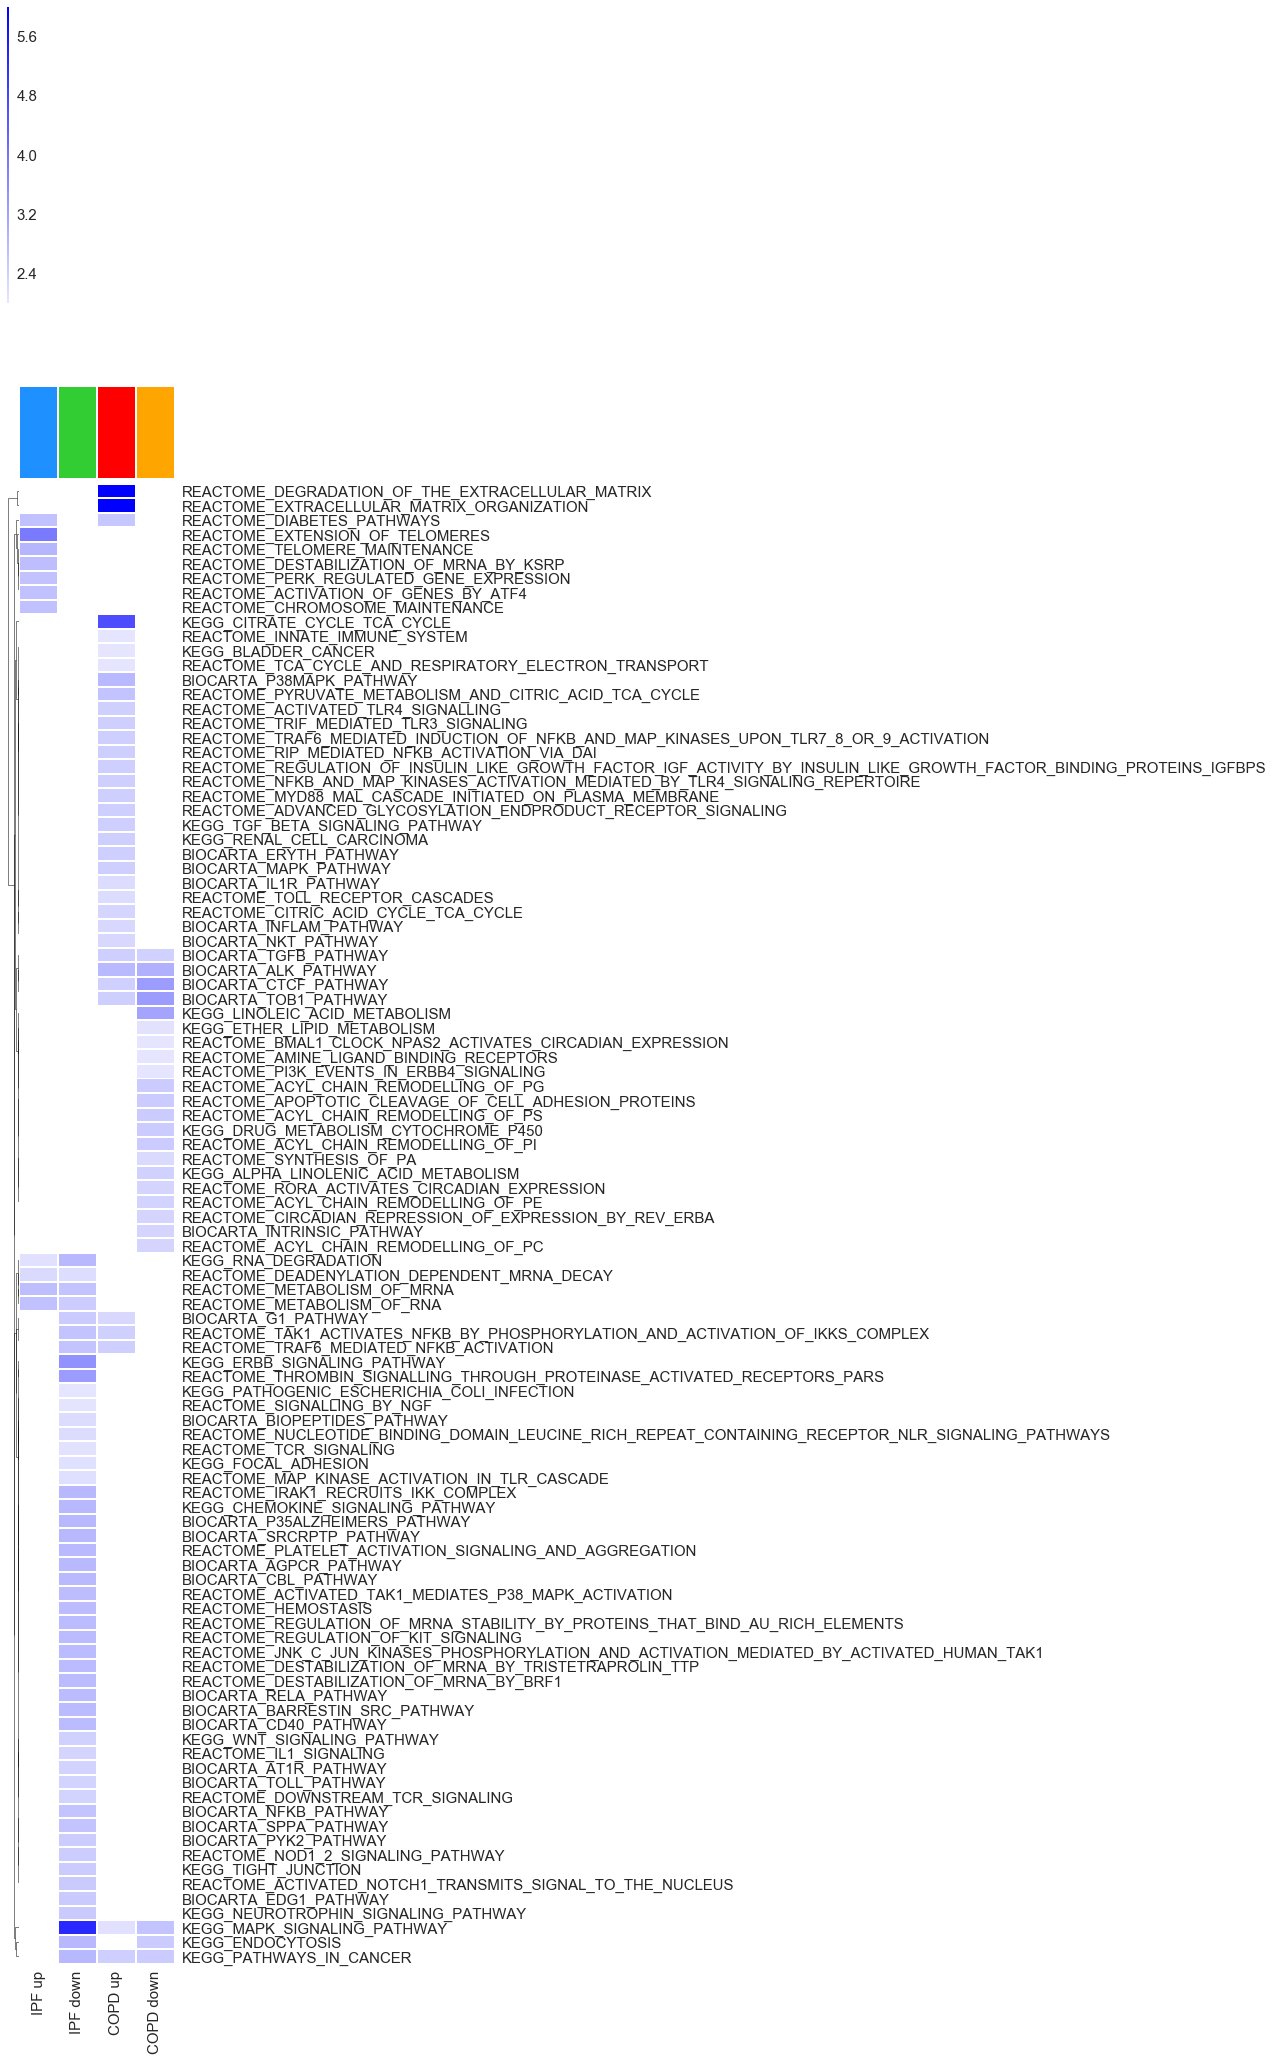

In [66]:
with sns.axes_style("white"):
    sns.clustermap(-np.log10(all_paths_pvals_df), cmap=sns.light_palette('b', n_colors=20, as_cmap=True),\
            linewidths=1, figsize=(3, 36), col_colors=['dodgerblue', 'limegreen', 'red', 'orange'], \
            vmin=-np.log10(a), vmax=6, mask=all_paths_pvals_df==1, \
                   col_cluster=False, yticklabels=all_paths_short)
    plt.savefig('/Users/arda/Desktop/COPD_IPF_all_paths_MSigDB_clus_FDR005_wseeds.pdf', format='pdf', \
                bbox_inches='tight')
    plt.show()

### NetPathScore for discordant and concordant pathways

In [67]:
def netpathscore(source_paths, target_module, interactome, sign_cutoff, Nrep, out_path, p_type='raw p-val'):
    
    # p_type examples: 'raw p-val', 'adj. p-val (Bonferroni)', 'FDR-BH'
    
    interactome_log_bins = np.unique(np.logspace(0, np.ceil(np.log10(max(dict(interactome.degree()).values()))), \
                                                 num=40).astype(int))
    
    deg_dict, deg_bin_dict = degree_log_bin(interactome, log_bins=interactome_log_bins)
    
    target_module_deg_dict, target_module_deg_bin_dict = degree_log_bin(interactome, nodes=target_module, \
                                                                    log_bins=interactome_log_bins)
    zscore = {}
    for path in source_paths[source_paths[p_type]<sign_cutoff]['pathway'].values:
        knn = []
        for gene in source_paths[source_paths['pathway']==path]['overlapping genes'].values[0].split(';'):
            knn.extend(nx.neighbors(interactome, str(gene.strip())))
        jaccard  = 1.0 * len(set(knn)&set(target_module)) / len(set(knn)|set(target_module))

        rand_jaccard = []
        for i in range(Nrep):
            rand_target_module = []
            for key in target_module_deg_bin_dict.keys():
                rand_target_module.extend(random.sample(set(deg_bin_dict[key]), len(target_module_deg_bin_dict[key]))) 
            rand_jaccard.append(1.0 * len(set(knn)&set(rand_target_module)) / len(set(knn)|set(rand_target_module)))

        zscore[path] = (jaccard - np.mean(rand_jaccard))/np.std(rand_jaccard)
 
    path_ranks_df = pd.DataFrame(index=source_paths[source_paths[p_type]<sign_cutoff]['pathway'], \
                                columns=['z-score', 'NetPathScore', 'Overrepresentation rank', 'NetPathScore rank'])
    for path in path_ranks_df.index:
        path_ranks_df.at[path, 'Overrepresentation rank'] = source_paths[source_paths['pathway']==path].index[0]
        path_ranks_df.at[path, 'z-score'] = zscore[path]
        path_ranks_df.at[path, 'NetPathScore'] = (zscore[path] - min(zscore.values())) /\
                                                   (max(zscore.values()) - min(zscore.values())) 
    path_ranks_df['NetPathScore rank'] = (path_ranks_df['NetPathScore'].rank(ascending=False).values - 1).astype(int)
    path_ranks_df.to_csv(out_path + '_ranks.csv')
    
    return path_ranks_df

#### COPD up pathways, ranked based on overlap with IPF module's up- and down-regulated genes

In [68]:
start = time.time()
COPD_up_IPF_up_ranks = netpathscore(copd_up_paths, IPF_up_rawp_entrez, G_ppi2015_LCC, 0.01, 5000, \
                                      '/Users/arda/Desktop/COPD_up_IPF_up', p_type='FDR-BH')
COPD_up_IPF_down_ranks = netpathscore(copd_up_paths, IPF_down_rawp_entrez, G_ppi2015_LCC, 0.01, 5000, \
                                      '/Users/arda/Desktop/COPD_up_IPF_down', p_type='FDR-BH')
print(time.time() - start)

406.072021008


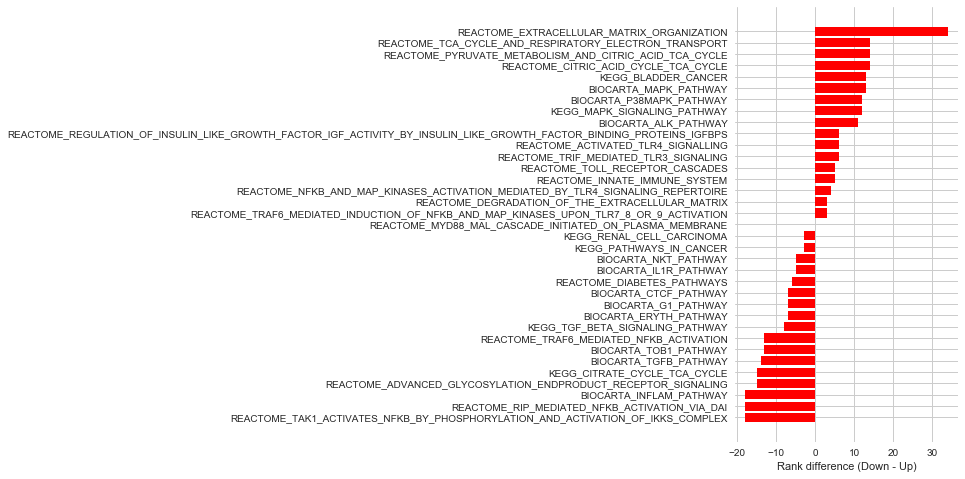

In [69]:
COPD_up_IPF_up_ranks.sort_index(inplace=True)
COPD_up_IPF_down_ranks.sort_index(inplace=True)
COPD_up_IPF_rankdiff = pd.DataFrame(index=COPD_up_IPF_up_ranks.index)
COPD_up_IPF_rankdiff['Rank difference (Down - Up)'] = COPD_up_IPF_down_ranks['NetPathScore rank'].values - \
                                                        COPD_up_IPF_up_ranks['NetPathScore rank'].values

sns.set(style="whitegrid")
n_groups = len(COPD_up_IPF_rankdiff)

f, ax = plt.subplots(figsize=(4, 8))

index = np.arange(n_groups)
bar_width = 0.8

rects1 = plt.barh(index + bar_width, COPD_up_IPF_rankdiff.sort_values('Rank difference (Down - Up)', \
            ascending=False)['Rank difference (Down - Up)'], bar_width, linewidth = 0, color='red', label='COPD_up')

plt.xlabel('Rank difference (Down - Up)')
plt.yticks(index + bar_width, COPD_up_IPF_rankdiff.sort_values('Rank difference (Down - Up)', ascending=False).index)
sns.despine(left=True, bottom=True)
plt.gca().invert_yaxis()
plt.savefig('/Users/arda/Desktop/COPD_up_IPF_rankdiff_FDR001.pdf', format='pdf', bbox_extra_artists=(), \
            bbox_inches='tight')
plt.show()

#### COPD down pathways, ranked based on overlap with IPF module's up- and down-regulated genes

In [70]:
start = time.time()
COPD_down_IPF_up_ranks = netpathscore(copd_down_paths, IPF_up_rawp_entrez, G_ppi2015_LCC, 0.01, 5000, \
                                      '/Users/arda/Desktop/COPD_down_IPF_up', p_type='FDR-BH')
COPD_down_IPF_down_ranks = netpathscore(copd_down_paths, IPF_down_rawp_entrez, G_ppi2015_LCC, 0.01, 5000, \
                                      '/Users/arda/Desktop/COPD_down_IPF_down', p_type='FDR-BH')
print(time.time() - start)

281.0280509


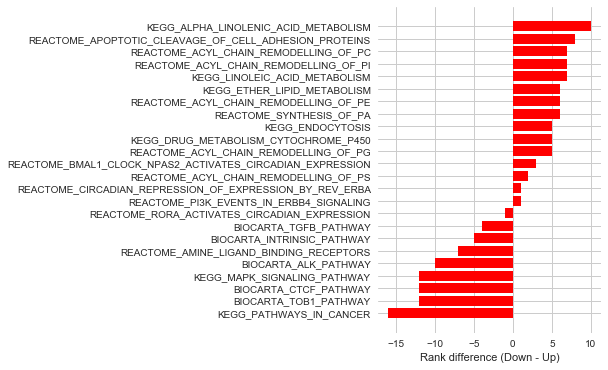

In [71]:
COPD_down_IPF_up_ranks.sort_index(inplace=True)
COPD_down_IPF_down_ranks.sort_index(inplace=True)
COPD_down_IPF_rankdiff = pd.DataFrame(index=COPD_down_IPF_up_ranks.index)
COPD_down_IPF_rankdiff['Rank difference (Down - Up)'] = COPD_down_IPF_down_ranks['NetPathScore rank'].values - \
                                                        COPD_down_IPF_up_ranks['NetPathScore rank'].values

sns.set(style="whitegrid")
n_groups = len(COPD_down_IPF_rankdiff)

f, ax = plt.subplots(figsize=(4, 6))

index = np.arange(n_groups)
bar_width = 0.8

rects1 = plt.barh(index + bar_width, COPD_down_IPF_rankdiff.sort_values('Rank difference (Down - Up)', \
            ascending=False)['Rank difference (Down - Up)'], bar_width, linewidth = 0, color='red', label='COPD_down')

plt.xlabel('Rank difference (Down - Up)')
plt.yticks(index + bar_width, COPD_down_IPF_rankdiff.sort_values('Rank difference (Down - Up)', ascending=False).index)
sns.despine(left=True, bottom=True)
plt.gca().invert_yaxis()
plt.savefig('/Users/arda/Desktop/COPD_down_IPF_rankdiff_FDR001.pdf', format='pdf', bbox_extra_artists=(), bbox_inches='tight')
plt.show()

#### IPF up pathways, ranked based on overlap with COPD module's up- and down-regulated genes

In [72]:
start = time.time()
IPF_up_COPD_up_ranks = netpathscore(ipf_up_paths, COPD_up_rawp_entrez, G_ppi2015_LCC, 0.01, 5000, \
                                      '/Users/arda/Desktop/IPF_up_COPD_up', p_type='FDR-BH')
IPF_up_COPD_down_ranks = netpathscore(ipf_up_paths, COPD_down_rawp_entrez, G_ppi2015_LCC, 0.01, 5000, \
                                      '/Users/arda/Desktop/IPF_up_COPD_down', p_type='FDR-BH')
print(time.time() - start)

263.102969885


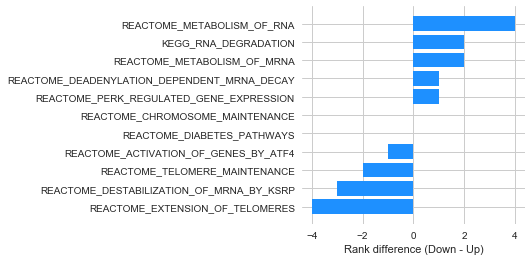

In [73]:
IPF_up_COPD_up_ranks.sort_index(inplace=True)
IPF_up_COPD_down_ranks.sort_index(inplace=True)
IPF_up_COPD_rankdiff = pd.DataFrame(index=IPF_up_COPD_up_ranks.index)
IPF_up_COPD_rankdiff['Rank difference (Down - Up)'] = IPF_up_COPD_down_ranks['NetPathScore rank'].values - \
                                                        IPF_up_COPD_up_ranks['NetPathScore rank'].values

sns.set(style="whitegrid")
n_groups = len(IPF_up_COPD_rankdiff)

f, ax = plt.subplots(figsize=(4, 4))

index = np.arange(n_groups)
bar_width = 0.8

rects1 = plt.barh(index + bar_width, IPF_up_COPD_rankdiff.sort_values('Rank difference (Down - Up)', \
            ascending=False)['Rank difference (Down - Up)'], bar_width, linewidth = 0, color='dodgerblue', label='IPF_up')

plt.xlabel('Rank difference (Down - Up)')
plt.yticks(index + bar_width, IPF_up_COPD_rankdiff.sort_values('Rank difference (Down - Up)', ascending=False).index)
sns.despine(left=True, bottom=True)
plt.gca().invert_yaxis()
plt.savefig('/Users/arda/Desktop/IPF_up_COPD_rankdiff_FDR001.pdf', format='pdf', bbox_extra_artists=(), bbox_inches='tight')
plt.show()

#### IPF down pathways, ranked based on overlap with COPD module's up- and down-regulated genes

In [74]:
start = time.time()
IPF_down_COPD_up_ranks = netpathscore(ipf_down_paths, COPD_up_rawp_entrez, G_ppi2015_LCC, 0.01, 5000, \
                                      '/Users/arda/Desktop/IPF_down_COPD_up', p_type='FDR-BH')
IPF_down_COPD_down_ranks = netpathscore(ipf_down_paths, COPD_down_rawp_entrez, G_ppi2015_LCC, 0.01, 5000, \
                                      '/Users/arda/Desktop/IPF_down_COPD_down', p_type='FDR-BH')
print(time.time() - start)

1239.812433


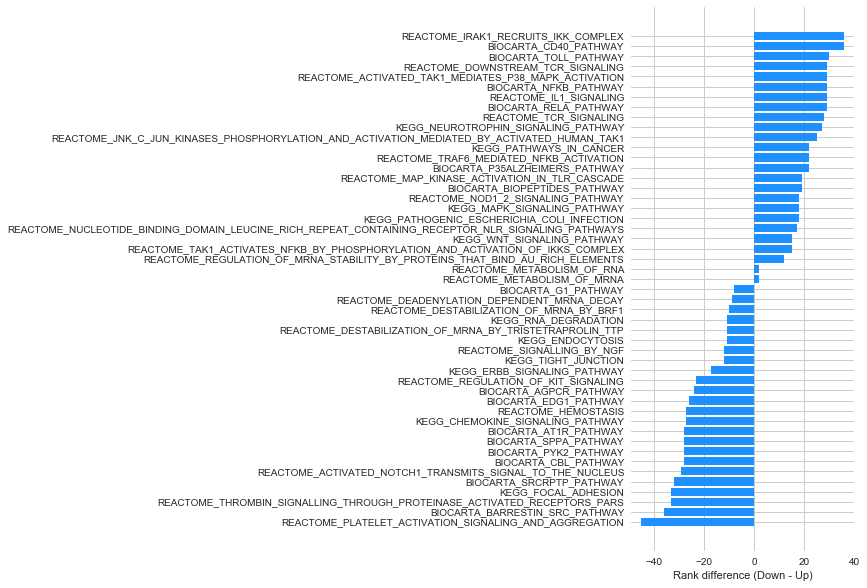

In [75]:
IPF_down_COPD_up_ranks.sort_index(inplace=True)
IPF_down_COPD_down_ranks.sort_index(inplace=True)
IPF_down_COPD_rankdiff = pd.DataFrame(index=IPF_down_COPD_up_ranks.index)
IPF_down_COPD_rankdiff['Rank difference (Down - Up)'] = IPF_down_COPD_down_ranks['NetPathScore rank'].values - \
                                                        IPF_down_COPD_up_ranks['NetPathScore rank'].values

sns.set(style="whitegrid")
n_groups = len(IPF_down_COPD_rankdiff)

f, ax = plt.subplots(figsize=(4, 10))

index = np.arange(n_groups)
bar_width = 0.8

rects1 = plt.barh(index + bar_width, IPF_down_COPD_rankdiff.sort_values('Rank difference (Down - Up)', \
    ascending=False)['Rank difference (Down - Up)'], bar_width, linewidth = 0, color='dodgerblue', label='IPF_down')

plt.xlabel('Rank difference (Down - Up)')
plt.yticks(index + bar_width, IPF_down_COPD_rankdiff.sort_values('Rank difference (Down - Up)', ascending=False).index)
sns.despine(left=True, bottom=True)
plt.gca().invert_yaxis()
plt.savefig('/Users/arda/Desktop/IPF_down_COPD_rankdiff_FDR001.pdf', format='pdf', bbox_extra_artists=(), bbox_inches='tight')
plt.show()

### 5/29/2018: visualization of NetPathScore pathways

In [76]:
path = 'REACTOME_EXTRACELLULAR_MATRIX_ORGANIZATION'
print len(copd_up_paths[copd_up_paths['pathway']==path]['overlapping genes'].values[0].split(';'))
knn = copd_up_paths[copd_up_paths['pathway']==path]['overlapping genes'].values[0].split(';')
for gene in copd_up_paths[copd_up_paths['pathway']==path]['overlapping genes'].values[0].split(';'):
    knn.extend(nx.neighbors(G_ppi2015_LCC, str(gene.strip())))

8


In [77]:
path = 'REACTOME_ADVANCED_GLYCOSYLATION_ENDPRODUCT_RECEPTOR_SIGNALING'
print len(copd_up_paths[copd_up_paths['pathway']==path]['overlapping genes'].values[0].split(';'))
knn = copd_up_paths[copd_up_paths['pathway']==path]['overlapping genes'].values[0].split(';')
for gene in copd_up_paths[copd_up_paths['pathway']==path]['overlapping genes'].values[0].split(';'):
    knn.extend(nx.neighbors(G_ppi2015_LCC, str(gene.strip())))

2


In [78]:
path = 'KEGG_MAPK_SIGNALING_PATHWAY'
print len(copd_up_paths[copd_up_paths['pathway']==path]['overlapping genes'].values[0].split(';'))
knn = copd_up_paths[copd_up_paths['pathway']==path]['overlapping genes'].values[0].split(';')
for gene in copd_up_paths[copd_up_paths['pathway']==path]['overlapping genes'].values[0].split(';'):
    knn.extend(nx.neighbors(G_ppi2015_LCC, str(gene.strip())))

4


In [79]:
path = 'REACTOME_TELOMERE_MAINTENANCE'
print len(ipf_up_paths[ipf_up_paths['pathway']==path]['overlapping genes'].values[0].split(';'))
knn = ipf_up_paths[ipf_up_paths['pathway']==path]['overlapping genes'].values[0].split(';')
for gene in ipf_up_paths[ipf_up_paths['pathway']==path]['overlapping genes'].values[0].split(';'):
    knn.extend(nx.neighbors(G_ppi2015_LCC, str(gene.strip())))

3


In [80]:
G_knn = nx.subgraph(G_ppi2015_LCC, knn)
print len(G_knn.nodes()), len(G_knn.edges())

539 10982


In [81]:
f = open('/Users/arda/Desktop/Telomere_extended_pathway_nodes.csv', 'w')
f.write('Id,Label,OverlapGene,Network\n')
for node in set(G_knn.nodes()) & set(symbol2entrez[:, 1]):
    if node in ipf_up_paths[ipf_up_paths['pathway']==path]['overlapping genes'].values[0].split(';'):
        f.write('%s,%s,Yes,ExtendedPathway\n' % (node, symbol2entrez[np.where(symbol2entrez[:, 1]==node)[0][0], 0]))
    else:
        f.write('%s,%s,No,ExtendedPathway\n' % (node, symbol2entrez[np.where(symbol2entrez[:, 1]==node)[0][0], 0]))
f.close()

f = open('/Users/arda/Desktop/Telomere_extended_pathway_edges.csv', 'w')
f.write('Source,Target,Type\n')
for e1, e2 in G_knn.edges():
    f.write('%s,%s,Undirected\n' % (e1, e2))
f.close()

In [82]:
G_ipf = nx.subgraph(G_ppi2015_LCC, ipf_module)
G_copd = nx.subgraph(G_ppi2015_LCC, copd_module)

In [83]:
f = open('/Users/arda/Desktop/ipf_module_directional_nodes.csv', 'w')
f.write('Id,Label,Direction,Network\n')
for node in G_ipf.nodes():
    if node in IPF_up_rawp_entrez:
        f.write('%s,%s,Up,Module\n' % (node, symbol2entrez[np.where(symbol2entrez[:, 1]==node)[0][0], 0]))
    elif node in IPF_down_rawp_entrez:
        f.write('%s,%s,Down,Module\n' % (node, symbol2entrez[np.where(symbol2entrez[:, 1]==node)[0][0], 0]))
    else:
        f.write('%s,%s,None,Module\n' % (node, symbol2entrez[np.where(symbol2entrez[:, 1]==node)[0][0], 0]))
f.close()

f = open('/Users/arda/Desktop/ipf_module_directional_edges.csv', 'w')
f.write('Source,Target,Type\n')
for e1, e2 in G_ipf.edges():
    f.write('%s,%s,Undirected\n' % (e1, e2))
f.close()

In [84]:
f = open('/Users/arda/Desktop/copd_module_directional_nodes.csv', 'w')
f.write('Id,Label,Direction,Network\n')
for node in set(G_copd.nodes()) - set(['730426']):
    if node in COPD_up_rawp_entrez:
        f.write('%s,%s,Up,Module\n' % (node, symbol2entrez[np.where(symbol2entrez[:, 1]==node)[0][0], 0]))
    elif node in COPD_down_rawp_entrez:
        f.write('%s,%s,Down,Module\n' % (node, symbol2entrez[np.where(symbol2entrez[:, 1]==node)[0][0], 0]))
    else:
        f.write('%s,%s,None,Module\n' % (node, symbol2entrez[np.where(symbol2entrez[:, 1]==node)[0][0], 0]))
f.close()

f = open('/Users/arda/Desktop/copd_module_directional_edges.csv', 'w')
f.write('Source,Target,Type\n')
for e1, e2 in G_copd.edges():
    f.write('%s,%s,Undirected\n' % (e1, e2))
f.close()

### Compare the COPD module with the COPD module from the Sci. Rep. paper

In [85]:
scirep_COPD_module = pd.read_csv(work_path + 'SciRep_paper_COPD_module.csv')

In [86]:
A = len(set(scirep_COPD_module['Gene-id'].values.astype(str)) & set(copd_module))
B = len(set(scirep_COPD_module['Gene-id'].values.astype(str)) - set(copd_module))
C = len(set(copd_module) - set(scirep_COPD_module['Gene-id'].values.astype(str)))
D = len(set(G_ppi2015_LCC.nodes()) - (set(scirep_COPD_module['Gene-id'].values.astype(str)) | set(copd_module)))

st.fisher_exact([[A, B], [C, D]])

(44.471451021477215, 5.630580612403969e-84)

In [87]:
print len(set(scirep_COPD_module['Gene-id'].values.astype(str)) & set(copd_module))
print len(set(scirep_COPD_module['Gene-id'].values.astype(str)) & set(G_ppi2015_LCC.nodes()) & set(copd_module))

80
80


In [88]:
overlap_symb = []
for gene in set(scirep_COPD_module['Gene-id'].values.astype(str)) & set(copd_module):
    overlap_symb.append(symbol2entrez[np.where(symbol2entrez[:, 1]==gene)[0][0], 0])

In [89]:
#print ('\n').join(sorted(overlap_symb))

### IPF and COPD DADA modules, excluding common genes (DSP and FAM13A)

In [90]:
DADA_COPD_exclude = np.genfromtxt(work_path + 'DADA_COPD_seeds_exclude.txt', dtype=str)
DADA_IPF_exclude = np.genfromtxt(work_path + 'DADA_IPF_seeds_exclude.txt', dtype=str)

In [91]:
# Can also be used with the original DADA file with the common genes ("copd_ppi2015_DADA.txt" and 
# "ipf_ppi2015_DADA.txt") 
start = time.time()
maxN = 60
stepsize = 10
lccs = np.zeros(maxN)
zscores = np.zeros(maxN)
seed_cov = np.zeros(maxN)
for i in np.arange(1, maxN):
    temp_sub = nx.subgraph(G_ppi2015_LCC, DADA_IPF_exclude[0:i*stepsize])
    temp_sub_lcc = max(nx.connected_component_subgraphs(temp_sub), key=len)
    lccs[i] = len(temp_sub_lcc)
    seed_cov[i] = 1.0 * len(set(temp_sub_lcc) & (set(ipf_seeds_entrez) & set(G_ppi2015_LCC))) / \
                                            len(set(ipf_seeds_entrez) & set(G_ppi2015_LCC))
    
    rand_lccs = []
    for n in np.arange(1000):
        rand_sub = nx.subgraph(G_ppi2015_LCC, random.sample(G_ppi2015_LCC.nodes(), len(temp_sub)))
        rand_sub_lcc = max(nx.connected_component_subgraphs(rand_sub), key=len)
        rand_lccs.append(len(rand_sub_lcc))
    zscores[i] = 1.0 * (len(temp_sub_lcc) - np.mean(rand_lccs)) / np.std(rand_lccs)
    print i,
print time.time() - start

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 1809.69464684


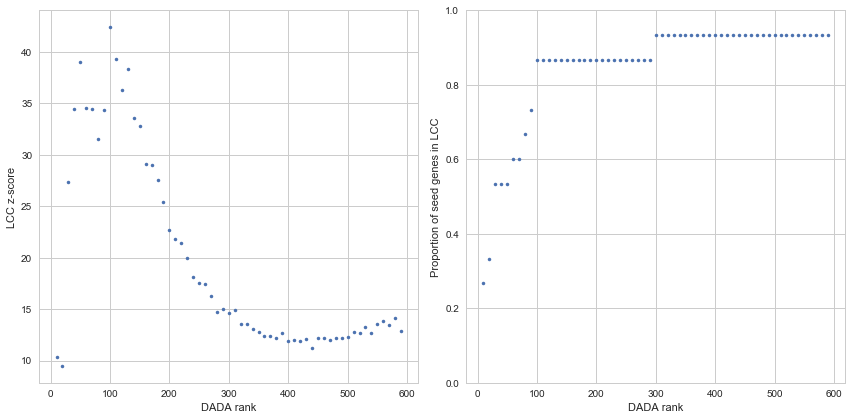

In [92]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2 ,1)
plt.plot(np.arange(1, maxN)*stepsize, zscores[1:], '.')
plt.xlabel('DADA rank')
plt.ylabel('LCC z-score')

plt.subplot(1, 2 ,2)
plt.plot(np.arange(1, maxN)*stepsize, seed_cov[1:], '.')
plt.xlabel('DADA rank')
plt.ylabel('Proportion of seed genes in LCC')
plt.ylim(0, 1.0)

plt.tight_layout()
plt.savefig('/Users/arda/Desktop/IPF_exclude_seeds_module_threshold.pdf', format='pdf')
plt.show()